In [1]:
!pip install -q tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [2]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv('GlobalLandTemperaturesByMajorCity.csv')
df['dt'] = pd.to_datetime(df['dt'])
df = df.dropna()


Saving GlobalLandTemperaturesByMajorCity.csv to GlobalLandTemperaturesByMajorCity.csv


In [3]:
city = 'Jakarta'
city_df = df[df['City'] == city]
city_df = city_df.sort_values('dt')
city_df = city_df[['dt', 'AverageTemperature']]

# Resample data bulanan (biar rapi)
city_df = city_df.set_index('dt').resample('M').mean()
city_df = city_df.dropna()


<ipython-input-3-76e20ac6af0d>:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  city_df = city_df.set_index('dt').resample('M').mean()


In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(city_df)

# Ubah ke bentuk dataframe lagi
scaled_df = pd.DataFrame(scaled_data, columns=['AverageTemperature'], index=city_df.index)


In [5]:
sequence_length = 12  # 12 bulan terakhir → prediksi bulan ke-13
X = []
y = []

for i in range(sequence_length, len(scaled_df)):
    X.append(scaled_df.iloc[i-sequence_length:i].values)
    y.append(scaled_df.iloc[i].values)

X, y = np.array(X), np.array(y)


In [6]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output suhu

model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
model.fit(X, y, epochs=25, batch_size=16)


Epoch 1/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0485
Epoch 2/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0175
Epoch 3/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0159
Epoch 4/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0151
Epoch 5/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0151
Epoch 6/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0127
Epoch 7/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0123
Epoch 8/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0099
Epoch 9/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0099
Epoch 10/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0105
Epoch 11/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0098
Epoch 12/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0094
Epoch 13/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0096
Epoch 14/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0087
Epoch 15/25
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s

In [8]:
predictions = []
last_sequence = scaled_df[-sequence_length:].values

for _ in range(12):  # prediksi 12 bulan ke depan
    input_seq = np.expand_dims(last_sequence, axis=0)
    next_temp = model.predict(input_seq)[0][0]
    predictions.append(next_temp)
    last_sequence = np.append(last_sequence[1:], [[next_temp]], axis=0)

# Balikkan ke skala asli
predicted_temps = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


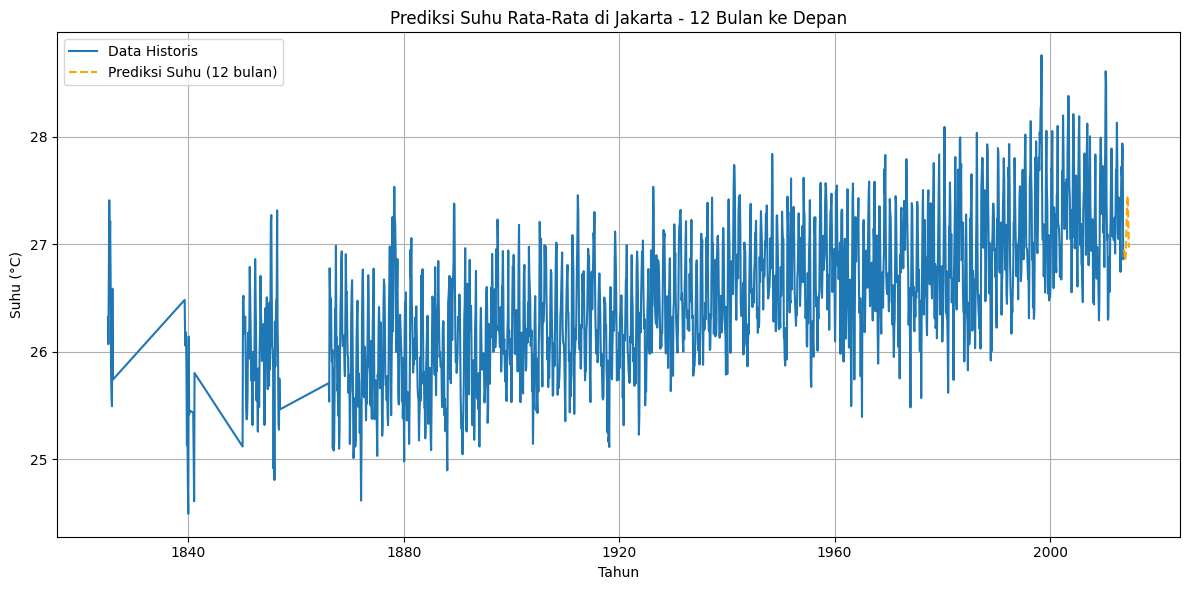

In [9]:
import datetime

last_date = city_df.index[-1]
future_dates = [last_date + datetime.timedelta(days=30 * i) for i in range(1, 13)]

plt.figure(figsize=(12, 6))
plt.plot(city_df.index, city_df['AverageTemperature'], label='Data Historis')
plt.plot(future_dates, predicted_temps, label='Prediksi Suhu (12 bulan)', linestyle='--', color='orange')
plt.title(f'Prediksi Suhu Rata-Rata di {city} - 12 Bulan ke Depan')
plt.xlabel('Tahun')
plt.ylabel('Suhu (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
asean_countries = [
    'Indonesia', 'Malaysia', 'Thailand', 'Singapore', 'Vietnam',
    'Philippines', 'Brunei', 'Cambodia', 'Laos', 'Myanmar', 'Timor-Leste'
]


In [12]:
asean_df = df[df['Country'].isin(asean_countries)]


In [14]:
asean_countries = [
    'Indonesia', 'Malaysia', 'Thailand', 'Singapore', 'Vietnam',
    'Philippines', 'Brunei', 'Cambodia', 'Laos', 'Myanmar', 'Timor-Leste'
]

asean_df = df[df['Country'].isin(asean_countries)]
asean_df['dt'] = pd.to_datetime(asean_df['dt'])
asean_df = asean_df.dropna()

selected_cities = asean_df['City'].unique()
print("Kota-kota ASEAN dalam dataset:", selected_cities)


Kota-kota ASEAN dalam dataset: ['Bangkok' 'Ho Chi Minh City' 'Jakarta' 'Manila' 'Singapore' 'Surabaya']


<ipython-input-14-e6b6a0eb041c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asean_df['dt'] = pd.to_datetime(asean_df['dt'])


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.preprocessing import MinMaxScaler

predictions_dict = {}

for city in selected_cities:
    city_df = asean_df[asean_df['City'] == city]
    city_df = city_df[['dt', 'AverageTemperature']].dropna()
    city_df = city_df.set_index('dt').resample('M').mean().dropna()

    if len(city_df) < 120:  # Butuh data cukup panjang
        continue

    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(city_df)

    X, y = [], []
    seq_len = 12
    for i in range(seq_len, len(scaled)):
        X.append(scaled[i-seq_len:i])
        y.append(scaled[i])
    X, y = np.array(X), np.array(y)

    # Reshape untuk LSTM
    X = X.reshape((X.shape[0], X.shape[1], 1))

    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    model.fit(X, y, epochs=5, batch_size=16, verbose=0)

    # Prediksi 12 bulan
    last_seq = scaled[-seq_len:]
    future_preds = []
    for _ in range(12):
        pred = model.predict(np.expand_dims(last_seq, axis=0))[0][0]
        future_preds.append(pred)
        last_seq = np.append(last_seq[1:], [[pred]], axis=0)

    future_temps = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))
    predictions_dict[city] = future_temps.flatten()


<ipython-input-15-50a7217b700c>:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  city_df = city_df.set_index('dt').resample('M').mean().dropna()
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


<ipython-input-15-50a7217b700c>:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  city_df = city_df.set_index('dt').resample('M').mean().dropna()
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


<ipython-input-15-50a7217b700c>:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  city_df = city_df.set_index('dt').resample('M').mean().dropna()
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


<ipython-input-15-50a7217b700c>:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  city_df = city_df.set_index('dt').resample('M').mean().dropna()
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


<ipython-input-15-50a7217b700c>:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  city_df = city_df.set_index('dt').resample('M').mean().dropna()
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


<ipython-input-15-50a7217b700c>:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  city_df = city_df.set_index('dt').resample('M').mean().dropna()
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


<ipython-input-17-110d5f9b156d>:16: UserWarning: Glyph 127759 (\N{EARTH GLOBE ASIA-AUSTRALIA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127759 (\N{EARTH GLOBE ASIA-AUSTRALIA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


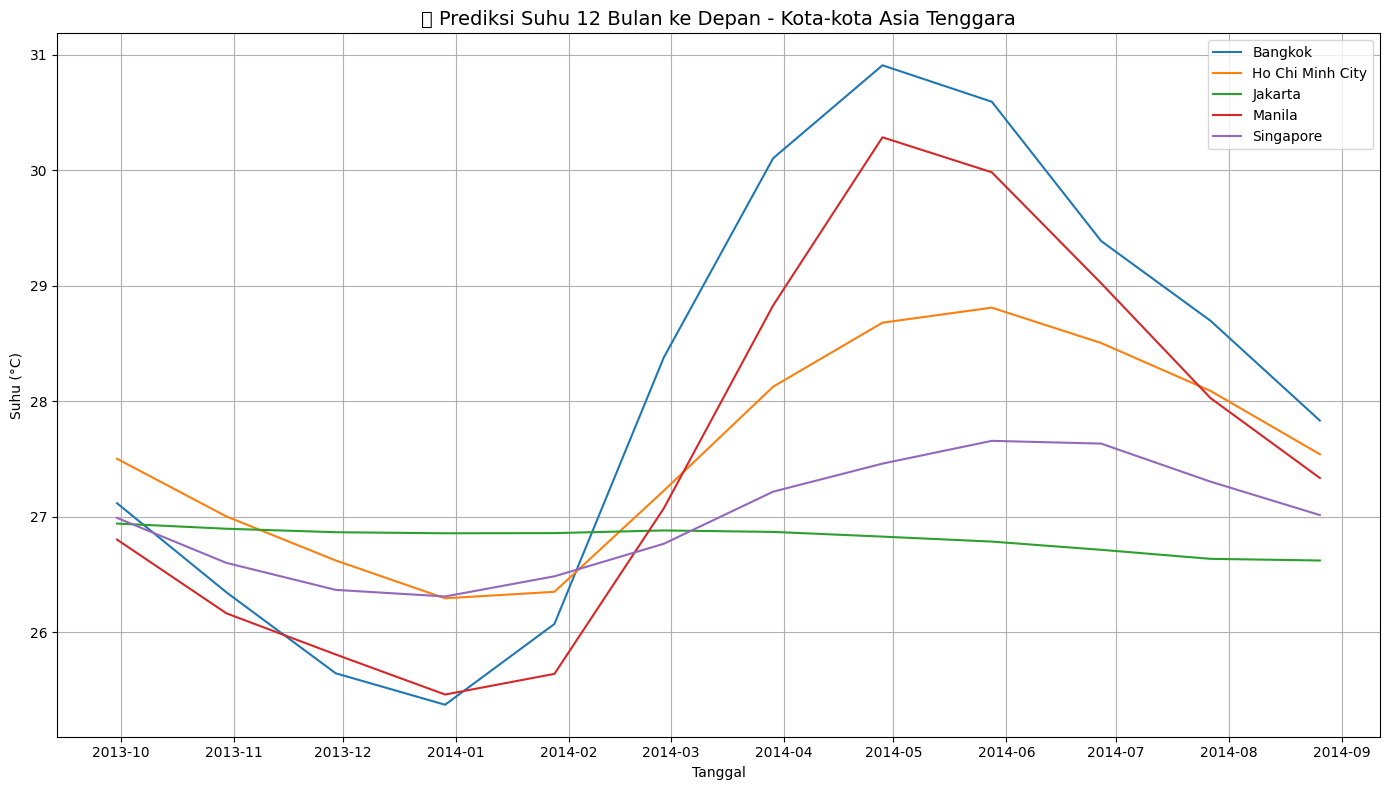

In [17]:
import matplotlib.pyplot as plt
import datetime

future_months = [city_df.index[-1] + datetime.timedelta(days=30*i) for i in range(1, 13)]

plt.figure(figsize=(14, 8))

for city, temps in predictions_dict.items():
    plt.plot(future_months, temps, label=city)

plt.title("🌏 Prediksi Suhu 12 Bulan ke Depan - Kota-kota Asia Tenggara", fontsize=14)
plt.xlabel("Tanggal")
plt.ylabel("Suhu (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-20-8720cd9cd169>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_df['year'] = city_df['dt'].dt.year
<ipython-input-20-8720cd9cd169>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_df['year'] = city_df['dt'].dt.year
<ipython-input-20-8720cd9cd169>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

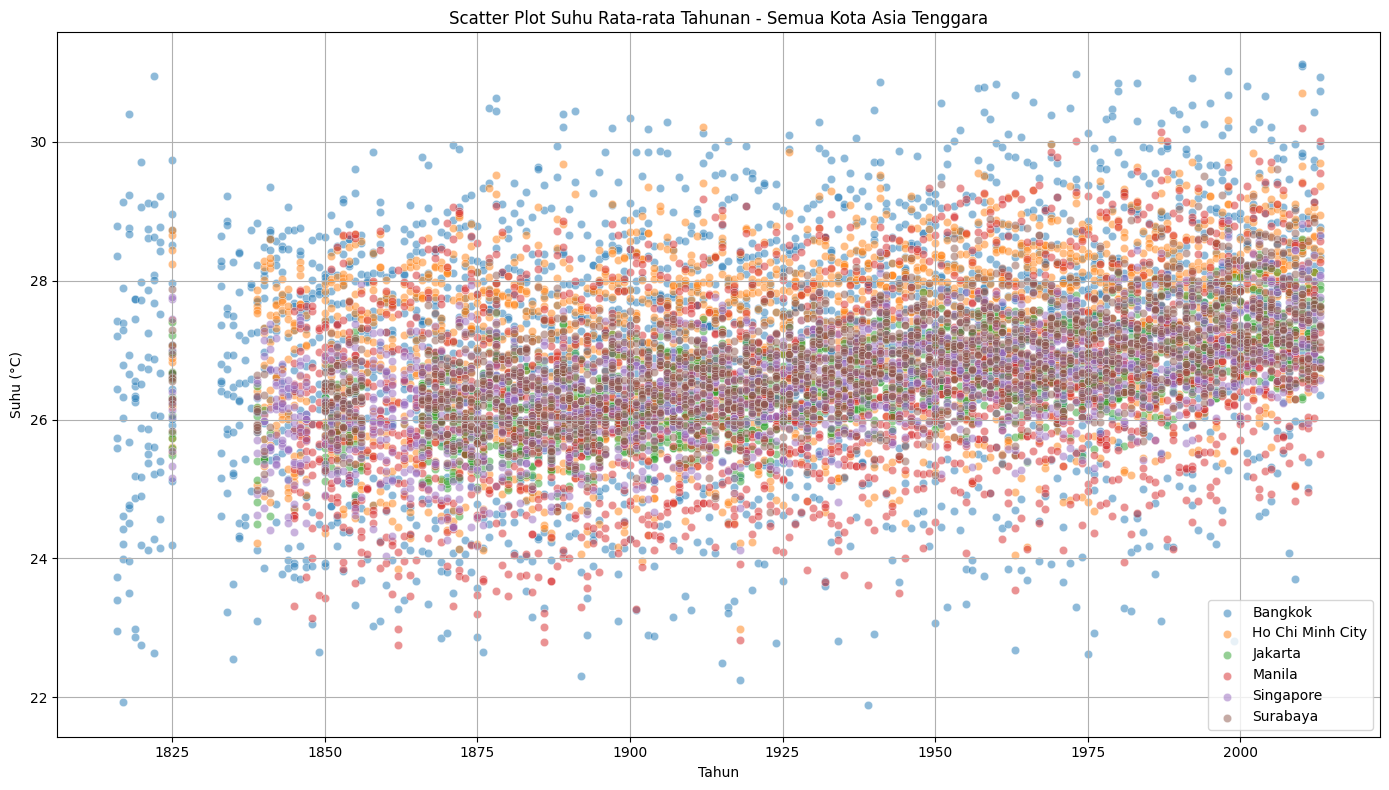

In [20]:
plt.figure(figsize=(14, 8))

for city in selected_cities:
    city_df = asean_df[asean_df['City'] == city]
    city_df['year'] = city_df['dt'].dt.year

    sns.scatterplot(data=city_df, x='year', y='AverageTemperature', label=city, alpha=0.5)

plt.title("Scatter Plot Suhu Rata-rata Tahunan - Semua Kota Asia Tenggara")
plt.xlabel("Tahun")
plt.ylabel("Suhu (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-22-b17a320305ee>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_df['year'] = city_df['dt'].dt.year
<ipython-input-22-b17a320305ee>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_df['month'] = city_df['dt'].dt.month
<ipython-input-22-b17a320305ee>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

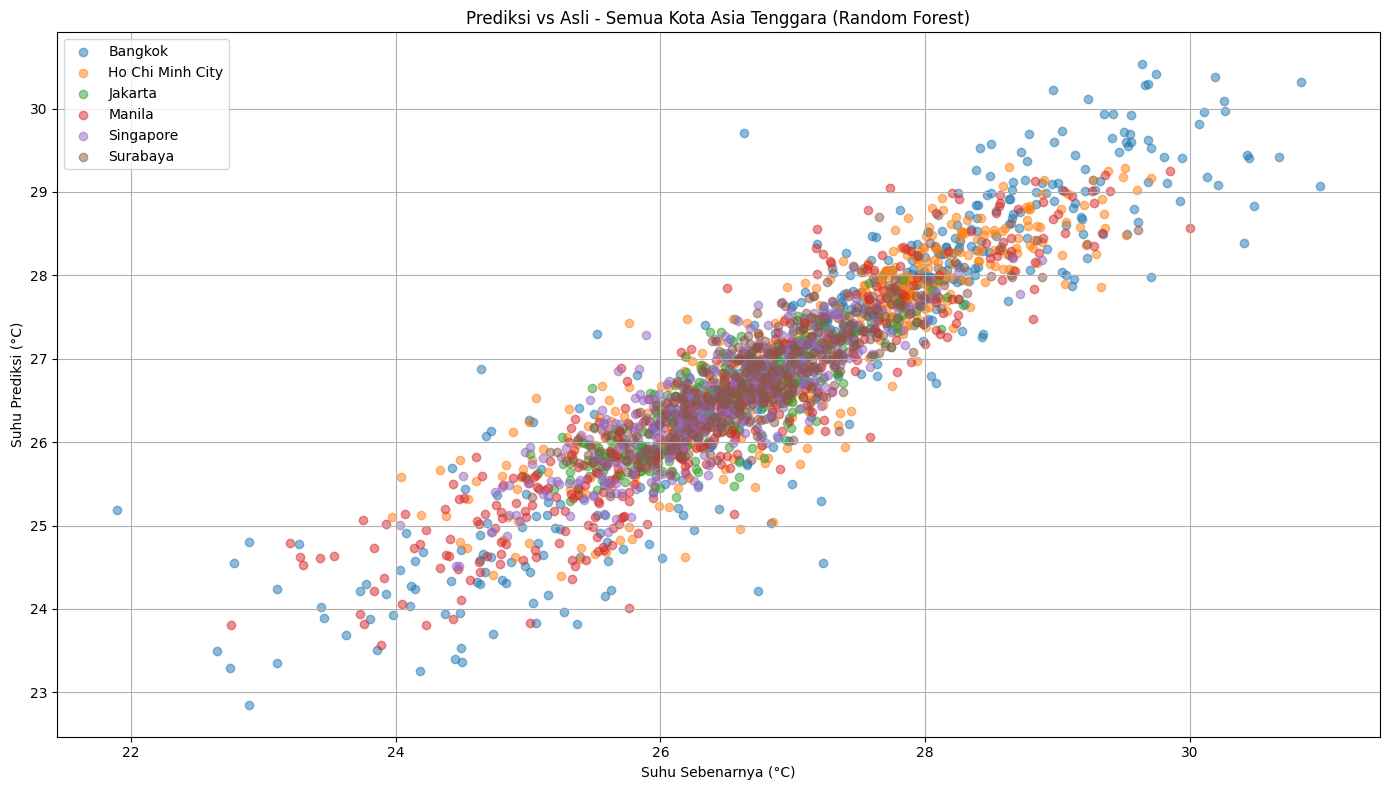

In [22]:
plt.figure(figsize=(14, 8))

for city in selected_cities:
    city_df = asean_df[asean_df['City'] == city]
    city_df['year'] = city_df['dt'].dt.year
    city_df['month'] = city_df['dt'].dt.month

    X = city_df[['year', 'month']]
    y = city_df['AverageTemperature']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)

    plt.scatter(y_test, y_pred, alpha=0.5, label=city)

plt.xlabel("Suhu Sebenarnya (°C)")
plt.ylabel("Suhu Prediksi (°C)")
plt.title("Prediksi vs Asli - Semua Kota Asia Tenggara (Random Forest)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

rf_results = {}

for city in selected_cities:
    city_df = asean_df[asean_df['City'] == city].dropna()
    city_df['year'] = city_df['dt'].dt.year
    city_df['month'] = city_df['dt'].dt.month

    X = city_df[['year', 'month']]
    y = city_df['AverageTemperature']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)


    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    rf_results[city] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    }

    print(f"\nEvaluasi {city}:")
    print(f"  MAE: {mae:.2f}")
    print(f"  MSE: {mse:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²: {r2:.2f}")

# Menampilkan hasil evaluasi untuk semua kota
print("\nEvaluasi untuk Semua Kota Asia Tenggara:")
for city, metrics in rf_results.items():
    print(f"{city}:")
    print(f"  MAE: {metrics['MAE']:.2f}, MSE: {metrics['MSE']:.2f}, RMSE: {metrics['RMSE']:.2f}, R²: {metrics['R²']:.2f}")



Evaluasi Bangkok:
  MAE: 0.47
  MSE: 0.45
  RMSE: 0.67
  R²: 0.84

Evaluasi Ho Chi Minh City:
  MAE: 0.41
  MSE: 0.29
  RMSE: 0.54
  R²: 0.80

Evaluasi Jakarta:
  MAE: 0.27
  MSE: 0.12
  RMSE: 0.35
  R²: 0.71

Evaluasi Manila:
  MAE: 0.42
  MSE: 0.29
  RMSE: 0.53
  R²: 0.84

Evaluasi Singapore:
  MAE: 0.29
  MSE: 0.14
  RMSE: 0.38
  R²: 0.74

Evaluasi Surabaya:
  MAE: 0.28
  MSE: 0.13
  RMSE: 0.35
  R²: 0.75

Evaluasi untuk Semua Kota Asia Tenggara:
Bangkok:
  MAE: 0.47, MSE: 0.45, RMSE: 0.67, R²: 0.84
Ho Chi Minh City:
  MAE: 0.41, MSE: 0.29, RMSE: 0.54, R²: 0.80
Jakarta:
  MAE: 0.27, MSE: 0.12, RMSE: 0.35, R²: 0.71
Manila:
  MAE: 0.42, MSE: 0.29, RMSE: 0.53, R²: 0.84
Singapore:
  MAE: 0.29, MSE: 0.14, RMSE: 0.38, R²: 0.74
Surabaya:
  MAE: 0.28, MSE: 0.13, RMSE: 0.35, R²: 0.75


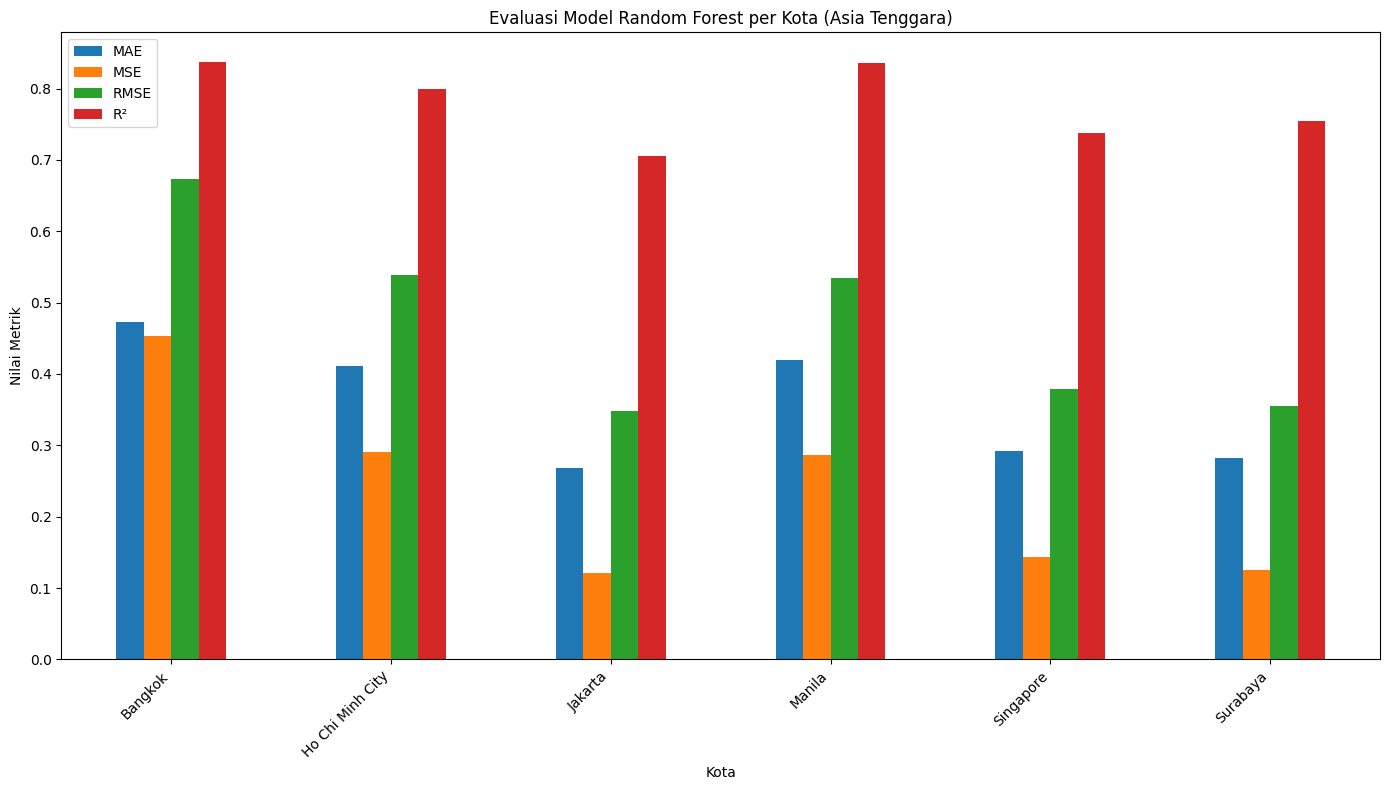

In [24]:
import matplotlib.pyplot as plt

# Visualisasi MAE, MSE, RMSE, R² untuk semua kota
metrics_df = pd.DataFrame(rf_results).T

metrics_df.plot(kind='bar', figsize=(14, 8))
plt.title("Evaluasi Model Random Forest per Kota (Asia Tenggara)")
plt.ylabel("Nilai Metrik")
plt.xlabel("Kota")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
